# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [11]:
import logging
import sys
import os
import time
import numpy

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [12]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [4]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [57]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [13]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [7]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [8]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [4]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

NameError: name 'example_document' is not defined

While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [14]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)
            topic_id = int(topic_id)
            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))
    topics = parse_topics([f_topics])

OrderedDict([(51, 'Airbus Subsidies'), (52, 'South African Sanctions'), (53, 'Leveraged Buyouts'), (54, 'Satellite Launch Contracts'), (55, 'Insider Trading'), (56, 'Prime (Lending) Rate Moves, Predictions'), (57, 'MCI'), (58, 'Rail Strikes'), (59, 'Weather Related Fatalities'), (60, 'Merit-Pay vs. Seniority'), (61, 'Israeli Role in Iran-Contra Affair'), (62, "Military Coups D'etat"), (63, 'Machine Translation'), (64, 'Hostage-Taking'), (65, 'Information Retrieval Systems'), (66, 'Natural Language Processing'), (67, 'Politically Motivated Civil Disturbances'), (68, 'Health Hazards from Fine-Diameter Fibers'), (69, 'Attempts to Revive the SALT II Treaty'), (70, 'Surrogate Motherhood'), (71, 'Border Incursions'), (72, 'Demographic Shifts in the U.S.'), (73, 'Demographic Shifts across National Boundaries'), (74, 'Conflicting Policy'), (75, 'Automation'), (76, 'U.S. Constitution - Original Intent'), (77, 'Poaching'), (78, 'Greenpeace'), (79, 'FRG Political Party Positions'), (80, '1988 Pre

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [15]:
import time
import pyndri

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

start_time = time.time()
document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 45.176279067993164 seconds.


In [260]:
import time


def run_retrieval(model_name, score_fn, parameter = None):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    data = {}
    
    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)

    with open('./ap_88_89/topics_title', 'r') as f_topics:
        query_list = parse_topics([f_topics])
        
    for query, sentence in query_list.items():
        print('{:.1f}s: {}'.format(time.time() - retrieval_start_time, query))
        query_ids = [token2id.get(word,0) for word in index.tokenize(sentence) if(token2id.get(word,0) > 0)]

        document_scores = []
        for document_id in range(index.document_base(), index.maximum_document()): # index.maximum_document()
            if document_lengths[document_id] > 0:
                document = index.document(document_id)
                score = score_fn(document_id, query_ids)
                document_scores.append((score, document[0]))

        sorted(document_scores, reverse = True)
        data[query] = document_scores               

    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

#run_retrieval('BM25', BM25)

In [168]:
def run_retrieval_PLM(model_name, score_fn, parameter = None):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    data = {}
    
    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)

    with open('./ap_88_89/topics_title', 'r') as f_topics:
        query_list = parse_topics([f_topics])
        
    for query, sentence in query_list.items():
        print('{:.1f}s: {}'.format(time.time() - retrieval_start_time, query))
        query_ids = [token2id.get(word,0) for word in index.tokenize(sentence) if(token2id.get(word,0) > 0)]
        
        document_scores = []
        for document_id in documents_1000[query]:
            int_doc_id = external2int[document_id]
            document = index.document(int_doc_id)
            score = score_fn(int_doc_id, query_ids, query)
            document_scores.append((score, document[0]))
            
        sorted(document_scores, reverse = True)
        data[query] = document_scores               
        

    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

run_retrieval_PLM('PLM', PLM_optimized)

Retrieving using PLM
0.0s: 51
2.5s: 52
20.3s: 53
21.7s: 54
29.6s: 55
35.5s: 56
45.4s: 57
45.7s: 58
49.3s: 59
54.6s: 60
60.7s: 61
81.3s: 62
94.8s: 63
96.7s: 64
101.5s: 65
108.9s: 66
113.4s: 67
120.5s: 68
130.2s: 69
140.1s: 70
140.5s: 71
146.7s: 72
154.7s: 73
158.2s: 74
163.7s: 75
163.8s: 76
172.8s: 77
173.0s: 78
173.5s: 79
193.2s: 80
204.7s: 81
214.6s: 82
217.0s: 83
221.8s: 84
238.2s: 85
244.1s: 86
252.8s: 87
263.8s: 88
278.4s: 89
286.5s: 90
302.4s: 91
316.2s: 92
329.3s: 93
335.9s: 94
342.9s: 95
352.0s: 96
362.8s: 97
364.5s: 98
370.1s: 99
382.8s: 100
389.5s: 101
409.8s: 102
430.9s: 103
435.8s: 104
447.1s: 105
460.0s: 106
472.7s: 107
484.0s: 108
493.1s: 109
501.4s: 110
525.4s: 111
535.0s: 112
536.6s: 113
549.6s: 114
556.3s: 115
566.0s: 116
583.6s: 117
593.7s: 118
598.1s: 119
602.6s: 120
612.0s: 121
618.8s: 122
634.2s: 123
641.9s: 124
648.1s: 125
660.5s: 126
670.0s: 127
686.0s: 128
691.9s: 129
711.5s: 130
723.9s: 131
734.9s: 132
740.2s: 133
748.9s: 134
756.7s: 135
761.7s: 136
764.9s: 137


In [169]:
index = pyndri.Index('index/')

external2int = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, _ = index.document(int_doc_id)
    external2int[ext_doc_id] = int_doc_id

In [9]:
def tfidf(int_document_id, query_term_ids):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    tfidf_score = 0
    
    for query_term_id in query_term_ids:
        tf = inverted_index[query_term_id].get(int_document_id, 0)
        num_of_document = index.maximum_document() - index.document_base()

        document_frequency = len(inverted_index[query_term_id])
        
        idf = numpy.log(num_of_document / document_frequency)

        #tf_idf = numpy.log(1+numpy.log(tf)) * idf
        #if tf is zero ???
        tf_idf = numpy.log(1+tf) * idf

        tfidf_score += tf_idf
        
    return tfidf_score

#print(tfidf(223, [8]))
print(tfidf(2, [5872, 3066]))


tfidf_query_env = pyndri.TFIDFQueryEnvironment(index)
results = tfidf_query_env.query(id2token[8], results_requested=10)

# combining the two functions above: 
#run_retrieval('tfidf', tfidf)


0.0


In [10]:
def BM25(int_document_id, query_term_ids, k1=1.2,b=0.75):
    
    BM25_score = 0
    for query_term_id in query_term_ids:
        tf = inverted_index[query_term_id].get(int_document_id, 0)
        idf = 0 
        num_of_document = index.maximum_document() - index.document_base()


        document_frequency = len(inverted_index[query_term_id])
        idf = numpy.log(num_of_document / document_frequency)

        nominator = ((k1 + 1) * tf) * idf
        denominator = k1 * ((1-b) + b * (document_lengths[int_document_id] / avg_doc_length)) + tf #document_length
        BM25_score += nominator / denominator
    
    return BM25_score

BM25(1, [11])

1.1846073783530506

In [104]:
def Jelinek_Mercer(int_document_id, query_term_ids, lambda_ = 0.3):
    
    JM_score = 0
    
    document_length = document_lengths[int_document_id]
    if document_length != 0:
        for query_term in query_term_ids:
            tf = inverted_index[query_term].get(int_document_id, 0)
            collect_term_freq = collection_frequencies[query_term_id] / float(total_terms)

            first = lambda_ * tf / document_length
            second = (1-lambda_) * collect_term_freq
            JM_score += first + second
    else:
        JM_score = 0
    
    return JM_score
    
Jelinek_Mercer(1, [11, 12])

0.0010395506405139004

In [105]:
run_retrieval('Jelinek-Mercer_0.3', Jelinek_Mercer)

Retrieving using Jelinek-Mercer_0.3
0.0s: 51


In [13]:
def Dirichlet(int_document_id,query_term_ids, mu=1500):
    num_of_document = index.maximum_document() - index.document_base()
    document_length = float(document_lengths[int_document_id])

    dirichlet_score = 0
    for query_term_id in query_term_ids:
        
        document_frequency = len(inverted_index[query_term_id])

        tf = inverted_index[query_term_id].get(int_document_id, 0)
        collect_term_freq = collection_frequencies[query_term_id] / float(total_terms)
        
        score = (tf + mu*collect_term_freq) / float(document_length + mu)
        dirichlet_score += score
    
    return dirichlet_score

Dirichlet(1, [11, 11])

0.00493691204460228

In [14]:
#run_retrieval('Dirichlet Prior_1500', Dirichlet) #[500, 1000, 1500]

In [184]:
corpus_size = sum([len(index.document(i)[1]) for i in range(index.document_base(), index.maximum_document())])


In [189]:
# Make corpus term frequency for language models with query terms only
corpus_term_freqs = collections.defaultdict(lambda: 0, key = 0)

for query_key in inverted_index.keys():
    for document_key in inverted_index[query_key].keys():
        corpus_term_freqs[query_key] += inverted_index[query_key][document_key]

In [261]:
def Absolute_Discounting(int_document_id,query_term_ids, delta = 0.5):
    document_length = float(document_lengths[int_document_id])
    unique_words = unique_terms_per_document.get(int_document_id, 0)
    if document_length == 0:
        return 0
    
    AD_score = 0
    for query_term_id in query_term_ids:
        document_term_freq = inverted_index[query_term_id].get(int_document_id, 0) 

        background_lm = background_model[query_term_id]
        score = (max(document_term_freq - delta, 0) / document_length
                 + (delta * unique_words / document_length) * background_lm)

        AD_score += numpy.log(score)
                
    return AD_score

In [262]:

with open('./ap_88_89/topics_title', 'r') as f_topics:
    query_list = parse_topics([f_topics])

sentence = query_list[107]
query_ids = [token2id.get(word,0) for word in index.tokenize(sentence) if(token2id.get(word,0) > 0)]

print(Absolute_Discounting(external2int['AP890217-0193'],query_ids))

print(Absolute_Discounting(external2int['AP880803-0278'],query_ids))
print(Absolute_Discounting(external2int['AP880218-0243'],query_ids))
print(Absolute_Discounting(external2int['AP880824-0081'],query_ids))


# print(absolute_discounting(external2int['AP891020-0110'], query_ids))


-20.498498202129973
-21.269758949343647
-22.177319747313014
-22.649386331692774


In [ ]:
run_retrieval('Absolute_Discounting_0.5-LAST', Absolute_Discounting) #[0.1, 0.5, 0.9]

Retrieving using Absolute_Discounting_0.5-LAST
0.0s: 51
8.0s: 52
16.5s: 53
24.6s: 54
34.2s: 55
43.0s: 56
53.6s: 57


In [17]:
import math
#Kernel Functions

def Gaussian(i, j, sigma):
    value = math.exp(-(i-j)**2 / 2*sigma**2)
    return value

def Triangle(i, j, sigma):
    if abs(i-j) <= sigma:
        value = 1 - abs(i-j)/sigma
    else:
        value =  0
    return value

def Cosine(i, j, sigma):
    if abs(i-j) <= sigma:
        value =  0.5 * (1+math.cos(abs(i-j)*math.pi/sigma))
    else:
        value = 0
    
    return value


def Circle(i, j, sigma):
    if abs(i-j) <= sigma:
        value = math.sqrt(1 - (abs(i-j)/sigma)**2)
    else:
        value = 0
    return value

# print(Circle(1,3,4))
# print(Cosine(1,3,4))
# print(Triangle(1,3,4))
# print(Gaussian(1,3,4))

def Passage(i, j, sigma):
    if abs(i-j) <= sigma:
        return 1
    else:
        return 0
    


In [18]:
# taken from https://introcs.cs.princeton.edu/java/21function/ErrorFunction.java.html
"""
// fractional error less than x.xx * 10 ^ -4.
    // Algorithm 26.2.17 in Abromowitz and Stegun, Handbook of Mathematical.
    public static double erf2(double z) {
        double t = 1.0 / (1.0 + 0.47047 * Math.abs(z));
        double poly = t * (0.3480242 + t * (-0.0958798 + t * (0.7478556)));
        double ans = 1.0 - poly * Math.exp(-z*z);
        if (z >= 0) return  ans;
        else        return -ans;
    }

    // cumulative normal distribution
    // See Gaussia.java for a better way to compute Phi(z)
    public static double Phi(double z) {
        return 0.5 * (1.0 + erf(z / (Math.sqrt(2.0))));
    }
"""

def erf2(z):
    t = 1.0 / (1.0 + 0.47047 * math.fabs(z))
    poly = t * (0.3480242 + t * (-0.0958798 + t * (0.7478556)))
    ans = 1.0 - poly * math.exp(-z*z)
    
    if z >= 0:
        return ans
    else:
        return -ans

def Phi(z):
    return 0.5 * (1.0 + erf2(z / (math.sqrt(2.0))))

In [77]:
##### PREPROCESS BEFORE PLM ##########

#### Get the first 1000 documents per query
file = open('tfidf.run', 'r')  
lines = file.readlines()

documents_1000 = {} ### dictionary query -> document

for line in lines:
    tokens = line.split()
    query = tokens[0]
    query_id = int(query)
    if query_id in documents_1000.keys():
        documents_1000[query_id].append(tokens[2])
    else:
        documents_1000[query_id] = [tokens[2]]
        


In [217]:
######### CREATING BACKGROUND LANGUAGE MODEL #####

from collections import defaultdict
import numpy as np

####### p(w|C) ######
background_model = defaultdict(lambda:0) #dictionary word -> P(w|C)
for doc_id in np.arange(index.document_base(), index.maximum_document()):
    doc = index.document(doc_id)
    for word in doc[1]:
        background_model[word] += 1


sum_ = sum(background_model.values())
for key in background_model.keys():
    background_model[key] = background_model[key]/sum_
#######################



In [22]:
######### INVERTED INDEX QUERY POSITIONS ###########
import time

term_positions_per_doc = {} #dictionary term -> {document_id -> positions}

start = time.time()
query_terms = set()
for key, value in tokenized_queries.items():
    for term in value:
        query_terms.add(term)  
i =0
for qt_id in query_terms:
    i += 1
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        tf = inverted_index[qt_id].get(int_doc_id, 0)
        if tf > 0:
            doc_term_ids = np.array(index.document(int_doc_id)[1])
            if not qt_id in term_positions_per_doc:
                term_positions_per_doc[qt_id] = {}
            term_positions_per_doc[qt_id][int_doc_id] = qt_positions
    #print('{:.3f}s: {}'.format(time.time() - start, i ))





In [161]:
def max_length():
    max_ = 0
    for document_id in range(index.document_base(), index.maximum_document()): 
        max_ = max(max_, len(index.document(document_id)[1]))
        
    return max_

max_length_ = max_length()

print(max_length_)

2939


In [167]:
######## CALCULATING Z VALUES IN ADVANCED #####

#Zi values per document length and position i
Z_values = {} #dictionary document_length -> list of i values from 0 to document length
min_length = min(document_lengths.values())
max_length = 2939
sigma = 50
for document_length in range(1, max_length+1):
    pos = []
    for i in range(0, document_length):
        zi = math.sqrt(2*math.pi*sigma*sigma)*(Phi((document_length-i)/sigma) - Phi((1-i)/sigma))
        pos.append(zi)
    Z_values[document_length] = pos



In [165]:
import numpy as np
######################################################################

def PLM_optimized(document_id ,query_id_tokens, query_id, kernel_method = Gaussian, mu=1000, sigma=50):
    document = index.document(document_id)
    document_terms = np.array(document[1])
    doc_length = len(document[1])
    
    sqd = -100000 # S(Q,D)
    
    run_per_query = time.time()

    #positions = [term_positions_per_doc[qt_id].get(document_id, []) for qt_id in query_id_tokens]
    
    positions = []
    
    for qt_id in query_id_tokens:
        if document_id in inverted_index[qt_id]:
            positions += term_positions_per_doc[qt_id].get(document_id, [])
        
    if not positions: # no query terms in document
        positions = [0] # position with lowest Zi value is at the edge
    pos_min = min(positions)
    pos_max = max(positions) + 1
    index_range = range(pos_min, pos_max)

    for i in index_range:
        sqdi = 0 # S(Q,D,i)
        
        zi = Z_values[doc_length][i]

        for query_term in set(query_id_tokens):
            C_wi = 0

            if document_id in inverted_index[query_term]:
                query_term_indices = term_positions_per_doc[query_term][document_id]

                for j in query_term_indices:
                    C_wi += kernel_method(i,j,sigma)

            pwc = background_model[query_term] # p(w|C)
         
            pwdi = (C_wi+mu*pwc) / (zi+mu) # p(w|D,i)

            pwq = 0 # p(w|Q)

            if query_term > 0:
                pwq = query_id_tokens.count(query_term) / float(len(query_id_tokens))       

            if pwq/pwdi != 0:
                sqdi -= pwq * math.log(pwq/pwdi)

        sqd = max(sqd, sqdi)

    #print('{:.4f}s: {}'.format(time.time() - run_per_query, sqd))

    return sqd


#query = "weather related fatalities"
#term_list = [token2id.get(term,0) for term in query.split()]
term_list = [19282,
  29,
  106525]
# term_list.append(363)
# term_list.append(880)
# term_list.append(1360)
#term_list.append(412)
#term_list.append(92160)



PLM_optimized(121854, [5465, 276, 1633, 1704, 3895], 76)


-7.761565215236459

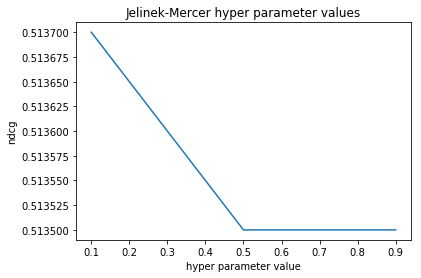

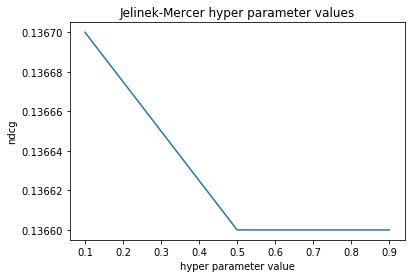

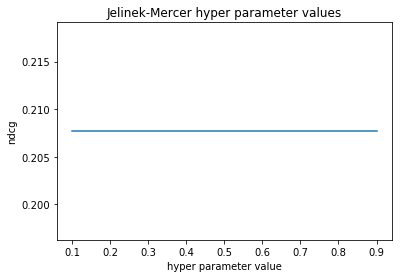

In [67]:
import matplotlib.pyplot as plt
import subprocess

def plot_parameter_values(model_name, params, measure):
    
    ndcgs = []
    for param in params:
        file_name = model_name + '_' + str(param) + '.run'
        
        ev_methods = measures[measure]
        qrel_set = 'ap_88_89/qrel_validation'
        cmd = '/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
        ndcg = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())
        ndcgs += [ndcg]
    
    plt.title(model_name + ' hyper parameter values')
    plt.plot(params, ndcgs)
    plt.xlabel('hyper parameter value')
    plt.ylabel('ndcg')
    plt.show()

plot_parameter_values('Jelinek-Mercer', [0.1, 0.5, 0.9], 'recall')
plot_parameter_values('Jelinek-Mercer', [0.1, 0.5, 0.9], 'map')
plot_parameter_values('Jelinek-Mercer', [0.1, 0.5, 0.9], 'ndcg')




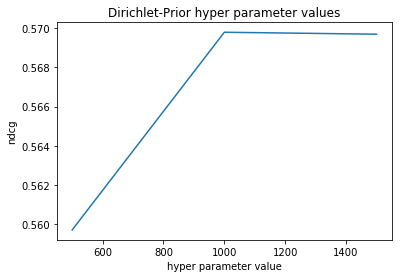

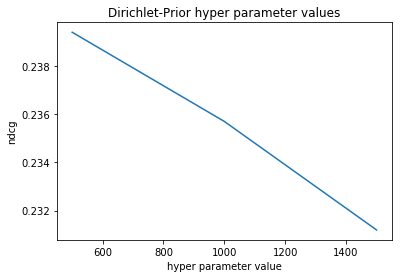

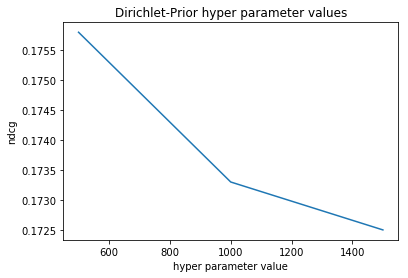

In [73]:
plot_parameter_values('Dirichlet-Prior', [500, 1000, 1500], "recall")
plot_parameter_values('Dirichlet-Prior', [500, 1000, 1500], "ndcg")
plot_parameter_values('Dirichlet-Prior', [500, 1000, 1500], "map")

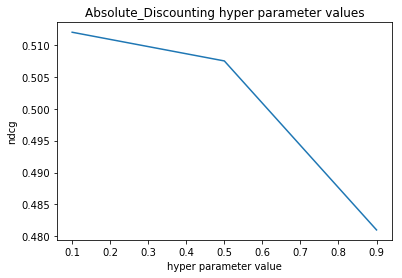

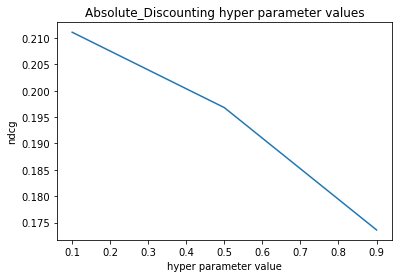

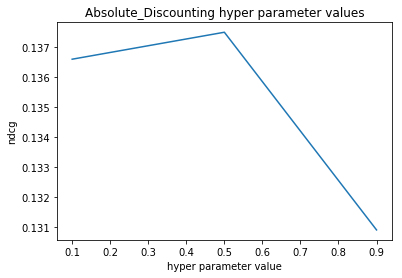

In [131]:
plot_parameter_values('Absolute_Discounting', [0.1, 0.5, 0.9], 'recall')
plot_parameter_values('Absolute_Discounting', [0.1, 0.5, 0.9], 'ndcg')
plot_parameter_values('Absolute_Discounting', [0.1, 0.5, 0.9], 'map')

In [162]:
import subprocess

# file_name = "tfidf" + '.run'
# file_name = 'Absolute_Discounting_0.5.run'
# file_name2 = 'absolute_discounting0.5.run'


# ev_methods = '(ndcg_cut_10(\s)*all)'
# qrel_set = 'ap_88_89/qrel_validation'
# cmd = '/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
# ndcg = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())

# print(ndcg)

# # os.system("/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q {1} {0} > {0}.txt".format(file_name, qrel_set))
# file_name = 'absolute_discounting0.5.run'


# ev_methods = '(ndcg_cut_10(\s)*all)'
# qrel_set = 'ap_88_89/qrel_validation'
# cmd = '/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
# ndcg = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())

# print(ndcg)


os.system("/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q ap_88_89/qrel_test 'absolute_discounting0.5.run' > 'absolute_discounting0.5.txt")

512

In [163]:
import subprocess

# file_name = "PLM" + '.run'
# ev_methods = '(recall_1000\s*all)'
# qrel_set = 'ap_88_89/qrel_validation'
# cmd = '/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
# recall_1000 = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())

# os.system("/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q {1} {0} > {0}.txt".format(file_name, qrel_set))

# file_name = 'absolute_discounting0.5.run'


os.system("/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q ap_88_89/qrel_test absolute_discounting0.5.run > absolute_discounting.txt")

0

In [143]:
import subprocess
from scipy import stats


def get_scores_per_query(filename, measure):
    file = open(filename, 'r')  
    lines = file.readlines()

    scores = []

    for line in lines:
        tokens = line.split()
        if tokens[0] == measure:
            scores.append(float(tokens[2]))

    return scores

# compare algorithms against tf-idf and perform t-test
measures = {}
measures["recall"] = '(recall_1000\s*all)'
measures["map"] = '(map_cut_1000\s*all)'
measures["ndcg"] = '(ndcg_cut_10(\s)*all)'

metrics = {}
metrics["recall"] = 'recall_1000'
metrics["map"] = 'map_cut_1000'
metrics["ndcg"] = 'ndcg_cut_10'




def get_eval_score(model_name, measure, param= None):
    
    if param == None:
        file_name = model_name + '.run'
    
    else:
        file_name = model_name + '_' + str(param) + '.run'

    print(file_name)
    
    ev_methods = measures[measure]
    
    qrel_set = 'ap_88_89/qrel_test'
    #cmd = '/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + ' | tee ' + "eval\/" +file_name + '.eval' 
    
    os.system("/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q {1} {0} > {0}.txt".format(file_name, qrel_set))
    
    cmd = '/Users/basaktugceeskili/trec_eval/trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods +'"'
    
    result_ave = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())
    print(result_ave)
    
    scores = get_scores_per_query(file_name +'.txt', metrics[measure])
    
    return scores



def get_test_scores(measure):
    scores_list = []
    scores_list.append(get_eval_score("tfidf",measure))
    scores_list.append(get_eval_score("BM25", measure)) 
    scores_list.append(get_eval_score("Jelinek-Mercer",measure, 0.5))
    scores_list.append(get_eval_score("Dirichlet-Prior", measure,500))
    scores_list.append(get_eval_score("Absolute_Discounting",measure, 0.5)) 
    scores_list.append(get_eval_score("PLM",measure)) 


    return scores_list
    
def t_test(scores_list, alpha = .05):
 
    # number of comparisons
    num_trials = len(scores_list)-1
    m1 = scores_list[0]
    pvalues = []
    t_stats = []
    for m2 in scores_list[1::]:
        t_stat, p_val = stats.ttest_rel(m1, m2)
        pvalues.append(p_val)
        t_stats.append(t_stat)
        
    #pvalues = np.asarray(pvalues) * num_trials
    return p_vals, np.asarray(t_stats)

scores_list = get_test_scores("ndcg")


tfidf.run
0.4169
BM25.run
0.4086
Jelinek-Mercer_0.5.run
0.1287
Dirichlet-Prior_500.run
0.1992
Absolute_Discounting_0.5.run
0.1471
PLM.run
0.1649


In [123]:
file_name = 'Absolute_Discounting_0.5-log.run.txt'
scores = get_scores_per_query(file_name, metrics["recall"])

len(scores_list[0])

121

In [144]:
print(stats.ttest_rel(scores_list[1], scores_list[4]))


Ttest_relResult(statistic=10.510327858672088, pvalue=1.0273007415380182e-18)


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

-1.2075766015838254


### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [1]:
# Training the Gensim word2vec model ourselves for 5 epochs, like in the example
# code. This process took about 90 minutes, so we pickled the final model (250MB)
# and provide it in our submission.

import copy
import pyndri
import pyndri.compat
import sys
import time
from gensim import corpora, models, similarities
import pickle
import gensim

start_time = time.time()
print('{:.1f}s: Loading pyndri index'.format(time.time() - start_time))
index = pyndri.Index('index/')
dictionary = pyndri.extract_dictionary(index)

print('{:.1f}s: Converting to IndriSentences'.format(time.time() - start_time))
sentences = pyndri.compat.IndriSentences(index, dictionary)

# print('{:.1f}s: Test IndriSentences'.format(time.time() - start_time))
# for i, doc in enumerate(sentences):
#     if i>=3:
#         break
#     print(doc)

is_model_trained_already = False
print('{:.1f}s: Loading cached Gensim word2vec model if available'.format(time.time() - start_time))
try:
    with open('trained_word2vec_after_5_epoch.pickle', 'rb') as f:
        gensim_embeddings = pickle.load(f).wv
    print('{:.1f}s: Loaded cached gensim word2vec model'.format(time.time() - start_time))
    is_model_trained_already = True
except:
    print('{:.1f}s: Nope'.format(time.time() - start_time))


if not is_model_trained_already:
    print('{:.1f}s: Starting process of training model (est. 90 minutes total)'.format(time.time() - start_time))
    print('{:.1f}s: Building vocab (estimated 220 seconds)'.format(time.time() - start_time))
    word2vec_init = gensim.models.Word2Vec(
        size=300,  # Embedding size
        window=5,  # One-sided window size
        sg=True,  # Skip-gram.
        min_count=5,  # Minimum word frequency.
        sample=1e-3,  # Sub-sample threshold.
        hs=False,  # Hierarchical softmax.
        negative=10,  # Number of negative examples.
        iter=1,  # Number of iterations.
        workers=8,  # Number of workers.
    )
    word2vec_init.build_vocab(sentences, trim_rule=None)
    
    print('{:.1f}s: Training word2vec'.format(time.time() - start_time))
    model = word2vec_init
    del word2vec_init
    for epoch in range(1, 5 + 1):
        print('{:.1f}s: start epoch {} of 5 (estimated 1000 seconds)'.format(time.time() - start_time, epoch))
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
        print('{:.1f}s: Saving model {} to pickle file'.format(time.time() - start_time, epoch))
        with open('trained_word2vec_after_{}_epoch.pickle'.format(epoch), 'wb') as f:
            pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
    
    print('{:.1f}s: Finished training word2vec model'.format(time.time() - start_time))
    gensim_embeddings = model.wv
    del model
    
print('{:.1f}s: Done for now'.format(time.time() - start_time))
del sentences

0.0s: Loading pyndri index
0.4s: Converting to IndriSentences
0.4s: Loading cached Gensim word2vec model if available
1.2s: Loaded cached gensim word2vec model
1.2s: Done for now


In [2]:
from gensim.models.keyedvectors import KeyedVectors
google_embeddings = KeyedVectors.load_word2vec_format('reduced_vectors_google.txt', binary=False)

FileNotFoundError: [Errno 2] No such file or directory: 'reduced_vectors_google.txt'

In [3]:
import numpy as np

# build document or query embedding by averaging the word embedding
def get_average_word_embedding (bow_of_input, embeddings, use_tfidf_weights=False):
    #embedding_size = embeddings.vector_size # doesn't work for gensim trained model ???
    embedding_size = embeddings[embeddings.index2word[0]].size
    total_embedding = np.zeros(embedding_size)
    for token_id, count in bow_of_input.items():
        word = dictionary.id2token[token_id]
        if not word in embeddings.vocab:
            continue
        embedding = embeddings[word]
        if use_tfidf_weights: # weigh each word by its discriminative power
            tf = 1 + np.log(bow_of_input.get(token_id, 1)) # log normalized
            df = len(inverted_index[token_id])
            if df == 0:
                weight = 0.0
            else:
                idf = num_documents / df
                weight = tf*idf
        else:
            weight = count # just simple average
        total_embedding += np.array(weight * embedding)
    total_embedding /= len(bow_of_input)
    return total_embedding

In [27]:
# collect all document embeddings (estimated 70 minutes)
import math
import time
start_time = time.time()
from collections import defaultdict
import collections


print('{:.1f}s: Collecting all document embeddings'.format(time.time() - start_time))

doc_embeddings_simple = {}
doc_embeddings_weighted = {}
doc_embeddings_simple_split = {}
doc_embeddings_weighted_split = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    if int_doc_id % 1000 == 0:
        print('{:.1f}s: {} out of {}'.format(time.time() - start_time, int_doc_id, index.maximum_document()))
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    
    doc_embeddings_simple[int_doc_id] = get_average_word_embedding(document_bow, gensim_embeddings)
    doc_embeddings_weighted[int_doc_id] = get_average_word_embedding(document_bow, gensim_embeddings, True)
    
    # split document into parts of M words and represent each part as a separate embedding
    doc_embeddings_simple_split[int_doc_id] = []
    doc_embeddings_weighted_split[int_doc_id] = []
    M = 100
    chunk_count = math.ceil(len(doc_token_ids)/M)
    chunks = []
    for i in range(chunk_count):
        chunks.append(doc_token_ids[i*M:(i+1)*M])
        if i < chunk_count - 1:
            offset = int(M/2)
            chunks.append(doc_token_ids[offset+i*M:offset+(i+1)*M])
    for chunk in chunks:
        chunk_bow = collections.Counter(
            token_id for token_id in chunk
            if token_id > 0)
        doc_embeddings_simple_split[int_doc_id].append(get_average_word_embedding(chunk_bow, gensim_embeddings))
        doc_embeddings_weighted_split[int_doc_id].append(get_average_word_embedding(chunk_bow, gensim_embeddings, True))
print('{:.1f}s: Done for now'.format(time.time() - start_time))

0.0s: Collecting all document embeddings


/Users/basaktugceeskili/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


21.7s: 1000 out of 164598
42.1s: 2000 out of 164598
62.9s: 3000 out of 164598
83.9s: 4000 out of 164598
103.2s: 5000 out of 164598


KeyboardInterrupt: 

In [19]:
from scipy import spatial

def simple_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings)
    doc_embedding = doc_embeddings_simple[int_document_id]
    cosine_similarity = 1 - spatial.distance.cosine(query_embedding, doc_embedding)
    return cosine_similarity


def weighted_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings, True)
    doc_embedding = doc_embeddings_weighted[int_document_id]
    cosine_similarity = 1 - spatial.distance.cosine(query_embedding, doc_embedding)
    return cosine_similarity


def simple_split_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings)
    doc_embeddings = doc_embeddings_simple_split[int_document_id]
    cosine_similarity = max([1 - spatial.distance.cosine(query_embedding, doc_embedding) for doc_embedding in doc_embeddings])
    return cosine_similarity


def weighted_split_embeddings_gensim (int_document_id, query_term_ids):
    query_bow = collections.Counter(
        token_id for token_id in query_term_ids
        if token_id > 0)
    query_embedding = get_average_word_embedding(query_bow, gensim_embeddings, True)
    doc_embeddings = doc_embeddings_weighted_split[int_document_id]
    cosine_similarity = max([1 - spatial.distance.cosine(query_embedding, doc_embedding) for doc_embedding in doc_embeddings])
    return cosine_similarity

In [29]:
# run experiment
#run_retrieval('simple word2vec (gensim)', simple_embeddings_gensim)
run_retrieval('weighted word2vec (gensim)', weighted_embeddings_gensim)
#run_retrieval('simple word2vec on document splits (gensim)', simple_split_embeddings_gensim)
run_retrieval('weighted word2vec on document splits (gensim)', weighted_split_embeddings_gensim)

Retrieving using weighted word2vec (gensim)
0.0s: 51


/Users/basaktugceeskili/anaconda/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Retrieving using weighted word2vec on document splits (gensim)
0.0s: 51


In [72]:
doc_embeddings_weighted[6528]

KeyError: 6528

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
